# Estimacion de la velocidad de rotacion terrestre

## A) Descarguen los datos experimentales de cada canal de observacion.

In [11]:
import os
import wget
import pandas as pd
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt

data_folder = 'Data'
if not os.path.exists(data_folder):
    os.mkdir(data_folder)

data_file = os.path.join(data_folder, 'DataRotacion.csv')
data_url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/DataRotacion.csv'

if not os.path.exists(data_file):
    wget.download(data_url, data_file)
    print('File loaded')

## B) Cargue los datos usando Pandas y haga un filtrado para obtener los datos correspondientes a λ = 30.


In [12]:
data = pd.read_csv(data_file)
angle_filter = data['angle'] == 30
filtered_data = data[angle_filter].copy()
h_values = np.array(filtered_data['h'])
y_values = np.array(filtered_data['y'])
sigmay_values = np.array(filtered_data['sigmay'])

## C) Defina el modelo fisico presentado para la desviacion por efecto coriolis. El modelo debe tener como entrada la altura inicial de caida h, el parametro de ajuste p = ω, la latitud λ y la aceleracion de la gravedad g.

In [13]:
def coriolis_model(h, lamb, p, g=9.81):
    y = 2 * np.sqrt(2) * (1 / 3) * p * np.cos(np.deg2rad(lamb)) * np.sqrt(h**3 / g)
    return y

## D) Defina la funcion χ^2, donde los argumentos son (h, y, sigmay, angle, g)

In [14]:
def funcion(p, h, y, sigmay, g=9.81, angle=30):
    model = coriolis_model(h, angle, p, g)
    residuals = y - model
    chi2 = np.sum(residuals**2 / (2 * sigmay**2))
    return chi2


## E) Minimice usando optimize. Para λ = 30, deberia obtener ω = 7.24 × 10^−5

In [15]:
p0 = np.ones(1)
minimize_options = {'disp': True}
result = spo.minimize(funcion, p0, args=(h_values, y_values, sigmay_values), options=minimize_options)
omega = result.x[0]
print("ω es:", omega)

Optimization terminated successfully.
         Current function value: 1.145718
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
ω es: 7.243998042010375e-05


## F) Dibuje los datos y el modelo para esa latitud.

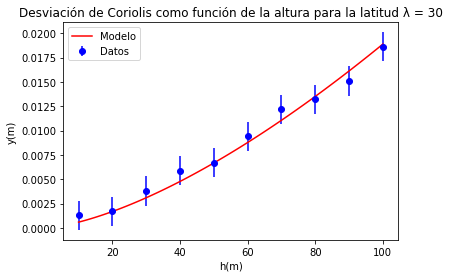

In [16]:
h_model = np.linspace(np.min(h_values), np.max(h_values), 100)
y_model = coriolis_model(h_model, 30, omega)
plt.errorbar(h_values, y_values, yerr=sigmay_values, fmt='o', color='blue', label="Datos")
plt.plot(h_model, y_model, 'r', label="Modelo")
plt.xlabel("h(m)")
plt.ylabel("y(m)")
plt.title("Desviación de Coriolis como función de la altura para la latitud λ = 30")
plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 3.912464
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
         Current function value: 2.710677
         Iterations: 2
         Function evaluations: 80
         Gradient evaluations: 34
         Current function value: 5.471557
         Iterations: 2
         Function evaluations: 96
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 4.864565
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
         Current function value: 6.593148
         Iterations: 2
         Function evaluations: 60
         Gradient evaluations: 24
         Current function value: 9.206922
         Iterations: 2
         Function evaluations: 62
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 5.091382
         Iterations: 3
         Function evaluatio

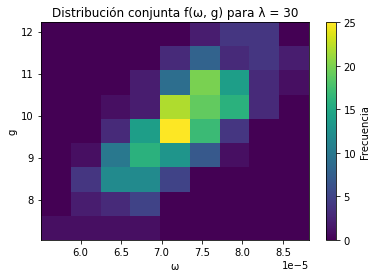

Correlación entre ω y g:
[[1.         0.76157768]
 [0.76157768 1.        ]]
Estimador mejor ω:  6.980134758330722e-05
Intervalo de confianza a 1σ:  [6.24404960623861e-05, 8.08426248646889e-05]
σ(+/-ω̂):  7.360851520921114e-06


In [42]:

num_samples = 300
gravity_samples = np.zeros(num_samples)
omega_samples = np.zeros(num_samples)

for i in range(num_samples):
    g = 9.81 + np.random.normal(loc=0, scale=1)
    gravity_samples[i] = g
    y_modified = y_values + np.random.normal(loc=0, scale=sigmay_values[0], size=len(y_values))
    result = spo.minimize(funcion, p0, args=(h_values, y_modified, sigmay_values, g, 30), options=minimize_options)
    omega = result.x[0]
    omega_samples[i] = omega

num_bins = 10
bins_omega = np.linspace(np.min(omega_samples), np.max(omega_samples), num_bins)
bins_gravity = np.linspace(np.min(gravity_samples), np.max(gravity_samples), num_bins)
histogram, _, _ = np.histogram2d(omega_samples, gravity_samples, bins=(bins_omega, bins_gravity))
plt.imshow(histogram.T, origin='lower', extent=[bins_omega[0], bins_omega[-1], bins_gravity[0], bins_gravity[-1]], aspect='auto', cmap='viridis')
plt.colorbar(label='Frecuencia')
plt.xlabel('ω')
plt.ylabel('g')
plt.title('Distribución conjunta f(ω, g) para λ = 30')
plt.show()

correlation = np.corrcoef(omega_samples, gravity_samples)
print("Correlación entre ω y g:")
print(correlation)
marginal_distribution = np.sum(histogram, axis=1)
cumulative_sum = np.cumsum(marginal_distribution)
lower_index = np.searchsorted(cumulative_sum, np.percentile(cumulative_sum, 16))
median_index = np.searchsorted(cumulative_sum, np.percentile(cumulative_sum, 50))
upper_index = np.searchsorted(cumulative_sum, np.percentile(cumulative_sum, 84))
best_estimate = bins_omega[median_index]
confidence_interval = [bins_omega[lower_index], bins_omega[upper_index]]
sigma_error = np.abs(confidence_interval[0] - best_estimate)
print("Estimador mejor ω: ", best_estimate)
print("Intervalo de confianza a 1σ: ", confidence_interval)
print("σ(+/-ω̂): ", sigma_error)
